In [3]:
from typing import NamedTuple, Any
from hypothesis_testing.bayes_factor import *
from hypothesis_testing import quad


def likelihood_null(y):
    """z = parameters of psd"""        
    sigma, tau = jnp.exp(y)
    S = psd.covariance(time, psd.drw_kernel(sigma, tau), mag_err)
    sqrt_cov = jnp.linalg.cholesky(S)
    return -periodogram.log_prob_null(data, sqrt_cov)


def prior_null(y):
    log_mu = jnp.log(jnp.array([0.1, 120.]))
    sigma = jnp.array([0.2, 0.9])
    return jnp.sum(0.5 * jnp.square((y - log_mu)/sigma) + 0.5 * jnp.log(2 * jnp.pi * jnp.square(sigma)))    
    
def posterior_null(y):
    return prior_null(y) + likelihood_null(y)


def quad_points(nlogp, MAP):
    
    x, w = quad.get_scheme(2, 6)

    d = len(MAP.y)
    ### go in the basis where the covariance matrix is the identity ###
    detCov = jnp.linalg.det(MAP.cov)
    D, Q = jnp.linalg.eigh(MAP.cov)
    
    M = jnp.sqrt(2)* jnp.dot(Q, jnp.diag(jnp.sqrt(D))) 
    
    def residual_integrand(X):
        z = jnp.dot(M, X) + MAP.y
        return jnp.exp(-nlogp(z) + MAP.nlogp + jnp.sum(jnp.square(X))) # residual integrand in this basis
    
    return jnp.exp(jnp.array([jnp.dot(M, X) + MAP.y for X in x]))

### analyze the null model ###
y_init = jnp.log(jnp.array([0.1, 120])) # mode of the prior distribution
map0 = optimize(posterior_null, y_init)
z = quad_points(posterior_null, map0)

OptimizeResults(x=Array([-2.2664545,  5.5562596], dtype=float32), success=Array(False, dtype=bool), status=Array(3, dtype=int32, weak_type=True), fun=Array(-768.5917, dtype=float32), jac=Array([-2.6287645e-04, -1.3090536e-05], dtype=float32), hess_inv=Array([[0.02631958, 0.0227842 ],
       [0.0227842 , 0.31700715]], dtype=float32), nfev=Array(11, dtype=int32, weak_type=True), njev=Array(11, dtype=int32, weak_type=True), nit=Array(7, dtype=int32, weak_type=True))
[[40.17335   -2.9623618]
 [-2.962289   3.3581982]]


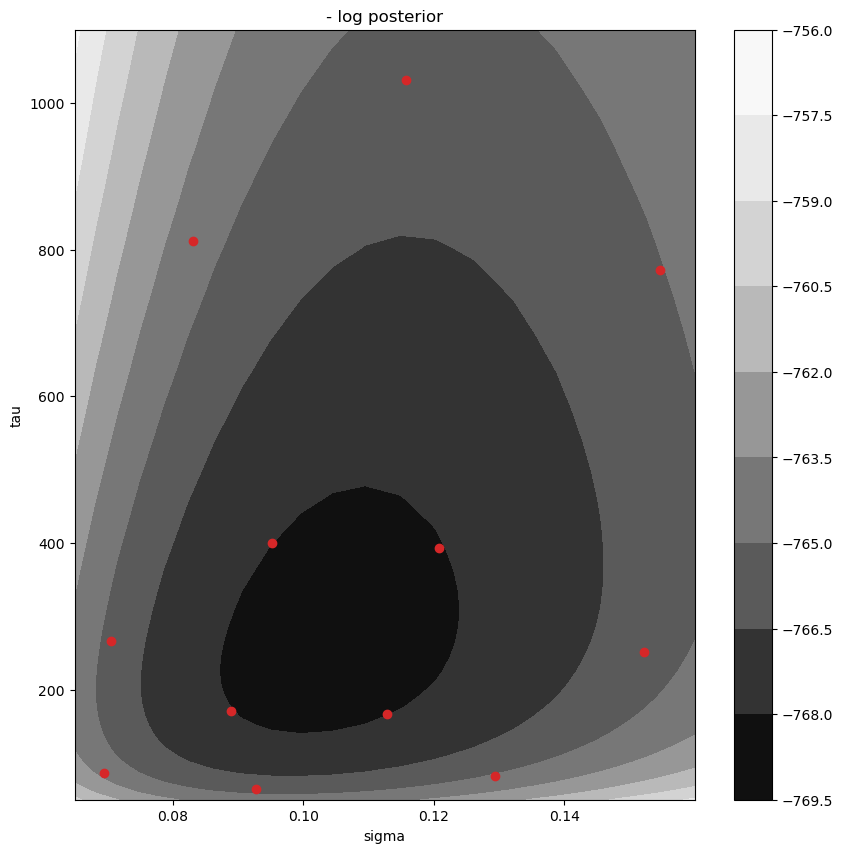